# Retrain translation model

Let's (1) assess the bias problem with a pretrained NMT model (from [MBART](https://huggingface.co/facebook/mbart-large-50); backup [here](https://huggingface.co/Helsinki-NLP/opus-mt-mul-en?text=el+ingeniero+se+cas%C3%B3+con+su+novio)); (2) retrain with same-gender and diff-gender data; (3) re-assess bias.

## Pretrain model
Let's follow the procedure [here](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/translation.ipynb#scrollTo=545PP3o8IrJV) to retrain the MBART model using ES-EN, FR-EN, IT-EN data from the TED talk corpus.

In [ ]:
from datasets import load_dataset


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_name = 'facebook/mbart-large'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir='data/')
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='data/')

In [2]:
## load model
# test 
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", cache_dir='data/model_cache/')
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", cache_dir='data/model_cache/')
# txt = "उसने अपने पति को चूमा"
# tokenizer.src_lang = "hi_IN"
# txt = "la femme s'est mariée avec son épouse"
# tokenizer.src_lang = "fr_XX"
## TODO: Spanish generates "committee" garbage
txt = "la mujer besó a su esposa"
tokenizer.src_lang = "es_XX"
# txt = "la donna baciò sua moglie"
# tokenizer.src_lang = "it_IT"
encoded_hi = tokenizer(txt, return_tensors="pt")
generated_tokens = model.generate(**encoded_hi, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
# model_inputs = tokenizer(src_text, return_tensors='pt')
# output = model.generate(**model_inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
# print(tokenizer.batch_decode(output))

["The Committee recommends that the State party take all necessary measures to ensure that the right to adequate housing is guaranteed in the State party's next periodic report, and that the State party take all necessary measures to ensure that the right to adequate housing is guaranteed in its next periodic report."]

## Load pretrained model

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_name = 'Helsinki-NLP/opus-mt-mul-en'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir='data/')
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir='data/')

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
import torch
test_sent = 'el abogado besó a su novia'
test_input = tokenizer(test_sent, return_tensors='pt')
with torch.no_grad():
    test_output = model.generate(**test_input)
print(tokenizer.batch_decode(test_output))

['<pad> the lawyer beats his girlfriend.']


### Evaluate model on diff-gender, same-gender sentences
Now that we've trained separate MT models on "default" data (EuroParl) and generated sample sentences for the same/diff gender sentences, let's see what the output looks like.

In [1]:
## load data
import pandas as pd
relationship_sentence_data = pd.read_csv('data/MT/translation_data_type=relationship_sentences.gz',
                                         sep='\t', compression='gzip')
# fix spacing??
relationship_sentence_data = relationship_sentence_data.assign(**{'sent' : relationship_sentence_data.loc[:, 'sent'].apply(lambda x: x.strip())})
display(relationship_sentence_data.head())

,sent,lang,subject_word,relationship_word,subject_gender,relationship_topic,relationship_gender,relationship_type,subject_word_en,relationship_word_en,relationship_word_category,sent_en
0,el analista conoció a su novio en una cita.,es,analista,novio,male,date,male,same_gender,analyst,boyfriend,FRIEND,the analyst met his boyfriend on a date.
1,el analista conoció a su prometido en una cita.,es,analista,prometido,male,date,male,same_gender,analyst,fiance,ENGAGE,the analyst met his fiancé on a date.
2,el analista conoció a su esposo en una cita.,es,analista,esposo,male,date,male,same_gender,analyst,husband,SPOUSE,the analyst met his husband on a date.
3,el artista conoció a su novio en una cita.,es,artista,novio,male,date,male,same_gender,artist,boyfriend,FRIEND,the artist met his boyfriend on a date.
4,el artista conoció a su prometido en una cita.,es,artista,prometido,male,date,male,same_gender,artist,fiance,ENGAGE,the artist met his fiancé on a date.


In [2]:
## load generated data
langs = relationship_sentence_data.loc[:, 'lang'].unique()
generated_data = []
for lang_i in langs:
    generated_data_file_i = f'data/MT/translation_data_type=relationship_lang={lang_i}/test_data_output.gz'
    generated_data_i = pd.read_csv(generated_data_file_i, sep='\t', compression='gzip')
    generated_data_i = generated_data_i.assign(**{'lang' : lang_i})
    generated_data.append(generated_data_i)
generated_data = pd.concat(generated_data).rename(columns={'input' : 'sent', 'output' : 'sent_en'})
display(generated_data.head())
## combine
generated_data = pd.merge(generated_data, relationship_sentence_data, on=['sent', 'sent_en', 'lang'])
print(generated_data.shape)
print(relationship_sentence_data.shape)

,sent,sent_en,pred,lang,output_tokens,pred_tokens,BLEU_score,ROUGE_score
0,el autor conoció a su novio en una cita.,the author met his boyfriend on a date.,The author met his new partner on a date.,es,NaN,NaN,NaN,NaN
1,el autor conoció a su prometido en una cita.,the author met his fiancé on a date.,The author met his promised son in a speech.,es,NaN,NaN,NaN,NaN
2,el autor conoció a su esposo en una cita.,the author met his husband on a date.,The author met his spouse at a date.,es,NaN,NaN,NaN,NaN
3,el panadero conoció a su novio en una cita.,the baker met his boyfriend on a date.,The panader met his new partner at a date.,es,NaN,NaN,NaN,NaN
4,el panadero conoció a su prometido en una cita.,the baker met his fiancé on a date.,The panader met his promise on a date.,es,NaN,NaN,NaN,NaN


(4038, 17)
(7380, 12)


In [3]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import match_category
from nltk.tokenize import WordPunctTokenizer
import re
MALE_PRO_MATCHER = re.compile('his')
FEMALE_PRO_MATCHER = re.compile('her')
matchers = [
    ('male', MALE_PRO_MATCHER),
    ('female', FEMALE_PRO_MATCHER),
]
tokenizer = WordPunctTokenizer()
generated_data = generated_data.assign(**{
    'subject_gender_pred' : generated_data.loc[:, 'pred'].apply(lambda x: match_category(tokenizer.tokenize(x), matchers))
})
generated_data = generated_data.assign(**{
    'subject_gender_match' : (generated_data.loc[:, 'subject_gender']==generated_data.loc[:, 'subject_gender_pred']).astype(int),
})
## overall
mean_match_vals = generated_data.groupby(['relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean())
sd_match_vals = generated_data.groupby(['relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].std() / x.shape[0]**.5)
overall_match_pct = pd.concat([mean_match_vals, sd_match_vals], axis=1).reset_index().rename(columns={0 : 'match_pct_mean', 1: 'match_pct_sd'})
display(overall_match_pct)
display(generated_data.groupby(['subject_gender', 'relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean()).reset_index(name='match_pct'))
display(generated_data.groupby(['lang', 'relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean()).reset_index(name='match_pct'))

,relationship_type,match_pct_mean,match_pct_sd
0,diff_gender,0.961614,0.004263
1,same_gender,0.903789,0.006586


,subject_gender,relationship_type,match_pct
0,female,diff_gender,0.946482
1,female,same_gender,0.870647
2,male,diff_gender,0.976540
3,male,same_gender,0.937063


,lang,relationship_type,match_pct
0,es,diff_gender,0.951852
1,es,same_gender,0.899074
2,fr,diff_gender,0.973077
3,fr,same_gender,0.919231
4,it,diff_gender,0.970930
5,it,same_gender,0.856164


OK! We have first (small) proof that training on default data produces a slight bias. 

Let's get some graphs to verify the significance.

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


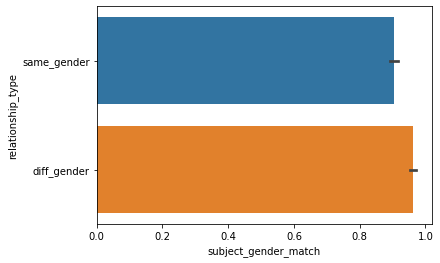

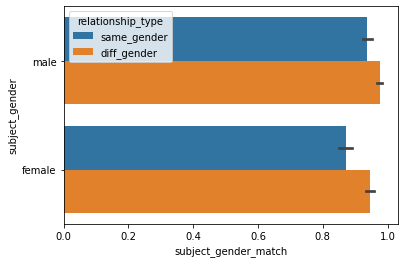

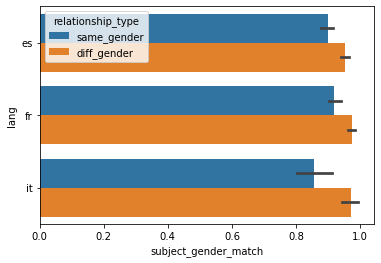

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
## flatten data for plot
flat_generated_data = pd.melt(generated_data, id_vars=['sent', 'relationship_type', 'subject_gender', 'lang'],
                              value_vars=['subject_gender_match'], value_name='subject_gender_match', var_name='match_type')
## overall
sns.barplot(data=flat_generated_data, y='relationship_type', x='subject_gender_match')
plt.show()
## per-type
type_vars = ['subject_gender', 'lang']
for type_var_i in type_vars:
    sns.barplot(data=flat_generated_data, y=type_var_i, x='subject_gender_match', hue='relationship_type')
    plt.show()

## Test performance after fine-tuning
We have now fine-tuned the translation models with the different/same gender data, and it looks like they're doing better!

Let's verify this.

In [5]:
## TODO: rerun w/ italian
## load original data
import pandas as pd
relationship_sentence_data = pd.read_csv('data/MT/translation_data_type=relationship_sentences.gz',
                                         sep='\t', compression='gzip')
# fix spacing??
relationship_sentence_data = relationship_sentence_data.assign(**{'sent' : relationship_sentence_data.loc[:, 'sent'].apply(lambda x: x.strip())})
## load generated data
langs = relationship_sentence_data.loc[:, 'lang'].unique()
# langs = ['es']
generated_data = []
for lang_i in langs:
    generated_data_file_i = f'data/MT/translation_data_type=relationship_lang={lang_i}/finetune/test_data_output.gz'
    generated_data_i = pd.read_csv(generated_data_file_i, sep='\t', compression='gzip')
    generated_data_i = generated_data_i.assign(**{'lang' : lang_i})
    generated_data.append(generated_data_i)
generated_data = pd.concat(generated_data).rename(columns={'input' : 'sent', 'output' : 'sent_en'})
## combine
generated_data = pd.merge(generated_data, relationship_sentence_data, on=['sent', 'sent_en', 'lang'])

In [6]:
display(generated_data.head(10))

,sent,sent_en,pred,lang,output_tokens,pred_tokens,BLEU_score,ROUGE_score,subject_word,relationship_word,subject_gender,relationship_topic,relationship_gender,relationship_type,subject_word_en,relationship_word_en,relationship_word_category
0,el profesor besó a su novio.,the professor kissed his boyfriend.,the teacher kissed his boyfriend.,es,NaN,NaN,NaN,NaN,profesor,novio,male,romance,male,same_gender,professor,boyfriend,FRIEND
1,la profesora se casó con su prometido.,the professor married her fiancé.,the teacher married her fiancé.,es,NaN,NaN,NaN,NaN,profesora,prometido,female,marriage,male,diff_gender,professor,fiance,ENGAGE
2,la bibliotecaria conoció a su esposa en una cita.,the librarian met her wife on a date.,the library met her wife on a date.,es,NaN,NaN,NaN,NaN,bibliotecaria,esposa,female,date,female,same_gender,librarian,wife,SPOUSE
3,el banquero besó a su novio.,the banker kissed his boyfriend.,the banker kissed his boyfriend.,es,NaN,NaN,NaN,NaN,banquero,novio,male,romance,male,same_gender,banker,boyfriend,FRIEND
4,el profesor se casó con su novio.,the professor married his boyfriend.,the teacher married his boyfriend.,es,NaN,NaN,NaN,NaN,profesor,novio,male,marriage,male,same_gender,professor,boyfriend,FRIEND
5,el arrendador conoció a su novio en una cita.,the landlord met his boyfriend on a date.,the realtor met his boyfriend on a date.,es,NaN,NaN,NaN,NaN,arrendador,novio,male,date,male,same_gender,landlord,boyfriend,FRIEND
6,el mecánico y su prometido tienen un hijo.,the mechanic and his fiancé have a child.,the mechanic and his fiancé have a child.,es,NaN,NaN,NaN,NaN,mecánico,prometido,male,family,male,same_gender,mechanic,fiance,ENGAGE
7,el bibliotecario conoció a su prometida en una...,the librarian met his fiancée on a date.,the library met his fiancée on a date.,es,NaN,NaN,NaN,NaN,bibliotecario,prometida,male,date,female,diff_gender,librarian,fiancee,ENGAGE
8,el banquero conoció a su novio en una cita.,the banker met his boyfriend on a date.,the bank met his boyfriend on a date.,es,NaN,NaN,NaN,NaN,banquero,novio,male,date,male,same_gender,banker,boyfriend,FRIEND
9,la bibliotecaria se casó con su novio.,the librarian married her boyfriend.,the library married her boyfriend.,es,NaN,NaN,NaN,NaN,bibliotecaria,novio,female,marriage,male,diff_gender,librarian,boyfriend,FRIEND


In [8]:
## compute match values
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import match_category
from nltk.tokenize import WordPunctTokenizer
import re
MALE_PRO_MATCHER = re.compile('his')
FEMALE_PRO_MATCHER = re.compile('her')
matchers = [
    ('male', MALE_PRO_MATCHER),
    ('female', FEMALE_PRO_MATCHER),
]
tokenizer = WordPunctTokenizer()
generated_data = generated_data.assign(**{
    'subject_gender_pred' : generated_data.loc[:, 'pred'].apply(lambda x: match_category(tokenizer.tokenize(x), matchers))
})
generated_data = generated_data.assign(**{
    'subject_gender_match' : (generated_data.loc[:, 'subject_gender']==generated_data.loc[:, 'subject_gender_pred']).astype(int),
})
## overall
mean_match_vals = generated_data.groupby(['relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean())
sd_match_vals = generated_data.groupby(['relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].std() / x.shape[0]**.5)
overall_match_pct = pd.concat([mean_match_vals, sd_match_vals], axis=1).reset_index().rename(columns={0 : 'match_pct_mean', 1: 'match_pct_sd'})
display(overall_match_pct)
display(generated_data.groupby(['subject_gender', 'relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean()).reset_index(name='match_pct'))
display(generated_data.groupby(['lang', 'relationship_type']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean()).reset_index(name='match_pct'))

,relationship_type,match_pct_mean,match_pct_sd
0,diff_gender,1.0,0.0
1,same_gender,1.0,0.0


,subject_gender,relationship_type,match_pct
0,female,diff_gender,1.0
1,female,same_gender,1.0
2,male,diff_gender,1.0
3,male,same_gender,1.0


,lang,relationship_type,match_pct
0,es,diff_gender,1.0
1,es,same_gender,1.0
2,fr,diff_gender,1.0
3,fr,same_gender,1.0
4,it,diff_gender,1.0
5,it,same_gender,1.0


OK! Even though we split the data by profession and the model has some knowledge gaps (ex. `realtor` vs. `landlord`), the translation models still generalize to new data.

We've also tested the translation models on the standard test data split, and we compute their accuracy before and after fine-tuning.

In [9]:
import pandas as pd
langs = ['es', 'fr', 'it']
accuracy_score_data = []
for lang_i in langs:
    pre_fine_tune_data_file_i = f'data/MT/data_{lang_i}/test_data_output.gz'
    post_fine_tune_data_file_i = f'data/MT/data_{lang_i}/translation_data_type=relationship_finetune/test_data_output.gz'
    pre_fine_tune_data_i = pd.read_csv(pre_fine_tune_data_file_i, sep='\t', compression='gzip')
    post_fine_tune_data_i = pd.read_csv(post_fine_tune_data_file_i, sep='\t', compression='gzip')
    pre_fine_tune_data_i = pre_fine_tune_data_i.assign(**{'data_type' : 'pre_fine_tune', 'lang' : lang_i})
    post_fine_tune_data_i = post_fine_tune_data_i.assign(**{'data_type' : 'post_fine_tune', 'lang' : lang_i})
    accuracy_score_data.extend([pre_fine_tune_data_i, post_fine_tune_data_i])
accuracy_score_data = pd.concat(accuracy_score_data, axis=0)
display(accuracy_score_data.head())

,input,output,pred,output_tokens,pred_tokens,BLEU_score,ROUGE_score,data_type,lang
0,¿Podríamos procurar que en la Carta de Derecho...,Can we make sure that the Charter of Fundament...,Can we try to include a section on children in...,"['Can', 'we', 'make', 'sure', 'that', 'the', '...","['Can', 'we', 'try', 'to', 'include', 'a', 'se...",0.330571,0.451613,pre_fine_tune,es
1,Los Estados miembros más débiles se ven obliga...,"However, the criteria for achieving nominal co...",The weaker Member States are forced to make cu...,"['However', ',', 'the', 'criteri', 'a', 'for',...","['The', 'we', 'a', 'ker', 'Member', 'States', ...",0.285991,0.564103,pre_fine_tune,es
2,Pero es algo distorsionante y peligroso y el R...,But it is disruptive and dangerous and the UK ...,"But that is distorting and dangerous, and the ...","['But', 'it', 'is', 'disrupt', 'ive', 'and', '...","['But', 'that', 'is', 'di', 'stor', 'ting', 'a...",0.194221,0.648649,pre_fine_tune,es
3,Les pido también que firmen la declaración esc...,I would ask you also to sign the written decla...,I also ask you to sign the written declaration...,"['I', 'would', 'ask', 'you', 'also', 'to', 'si...","['I', 'also', 'ask', 'you', 'to', 'sign', 'the...",0.320771,0.687500,pre_fine_tune,es
4,La ha mencionado entre otras muchas.,You mentioned it among many others.,You mentioned it among many others.,"['You', 'mentioned', 'it', 'among', 'many', 'o...","['You', 'mentioned', 'it', 'among', 'many', 'o...",1.000000,1.000000,pre_fine_tune,es


In [10]:
## overall scores
def compute_mean_sd_scores(data, score_vars):
    mean_accuracy_score_data = data.groupby('data_type').apply(lambda x: x.loc[:, score_vars].mean(axis=0).rename({score_var_i : f'{score_var_i}_mean' for score_var_i in score_vars}))
    sd_accuracy_score_data = data.groupby('data_type').apply(lambda x: x.loc[:, score_vars].std(axis=0).rename({score_var_i : f'{score_var_i}_sd' for score_var_i in score_vars}))
    mean_accuracy_score_data = pd.concat([mean_accuracy_score_data, sd_accuracy_score_data], axis=1)
    mean_accuracy_score_data = mean_accuracy_score_data.loc[:, list(sorted(mean_accuracy_score_data.columns))]
    return mean_accuracy_score_data
score_vars = ['BLEU_score', 'ROUGE_score']
mean_accuracy_score_data = compute_mean_sd_scores(accuracy_score_data, score_vars)
display(mean_accuracy_score_data)

,BLEU_score_mean,BLEU_score_sd,ROUGE_score_mean,ROUGE_score_sd
data_type,,,,
post_fine_tune,0.326675,0.224455,0.603307,0.179311
pre_fine_tune,0.364572,0.234060,0.622618,0.181349


In [11]:
per_lang_mean_accuracy_score_data = accuracy_score_data.groupby('lang').apply(lambda x: compute_mean_sd_scores(x, score_vars))
display(per_lang_mean_accuracy_score_data)

BLEU_score_mean  BLEU_score_sd  ROUGE_score_mean  \
lang data_type                                                          
es   post_fine_tune         0.316265       0.226714          0.607950   
     pre_fine_tune          0.395678       0.243007          0.650670   
fr   post_fine_tune         0.332848       0.225440          0.602346   
     pre_fine_tune          0.353473       0.229886          0.612711   
it   post_fine_tune         0.330911       0.220824          0.599625   
     pre_fine_tune          0.344566       0.225769          0.604474   

                     ROUGE_score_sd  
lang data_type                       
es   post_fine_tune        0.177255  
     pre_fine_tune         0.181810  
fr   post_fine_tune        0.180182  
     pre_fine_tune         0.177910  
it   post_fine_tune        0.180396  
     pre_fine_tune         0.180963